In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
tf.random.set_seed(1234)

Import the data

In [3]:
#import the data
df = pd.read_excel("../../../site_info_ver_4_lite.xlsx")
df.reset_index(drop=True,inplace=True)

In [4]:
tmp = df.loc[df.Site_Name == 'En Afek']
tmp.set_index('Date', drop=True , inplace= True)

In [5]:
tmp.drop(['Site_Name','Tourists_Count','Total'], inplace = True, axis = 1)

In [6]:
target = 'Israelis_Count'

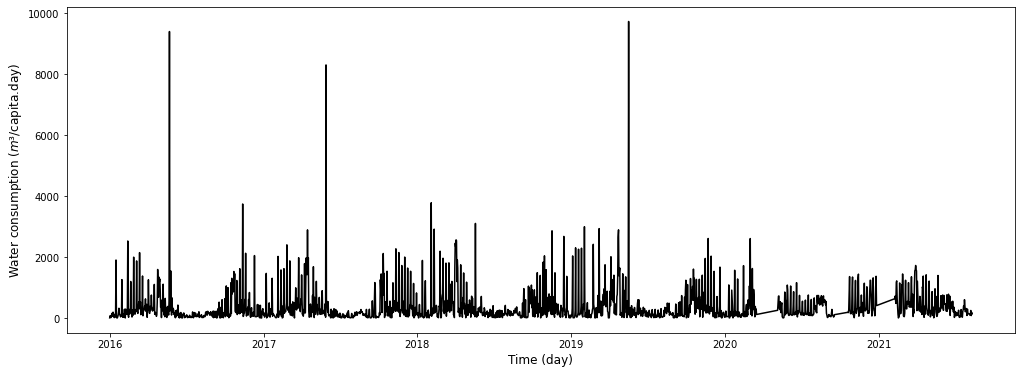

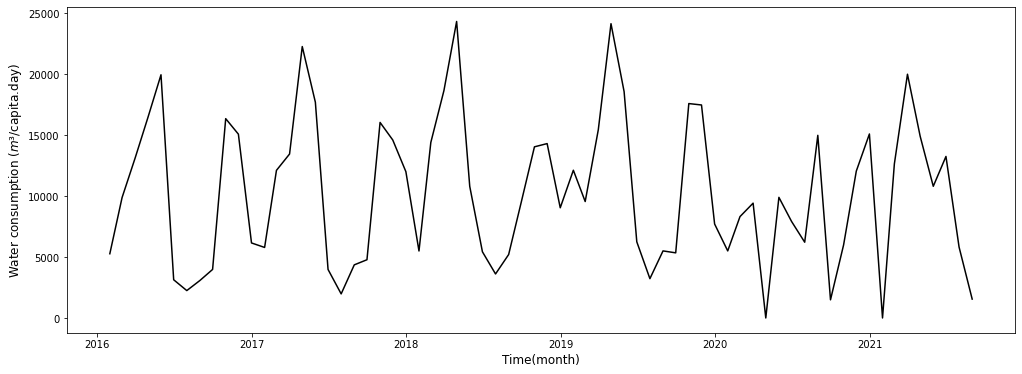

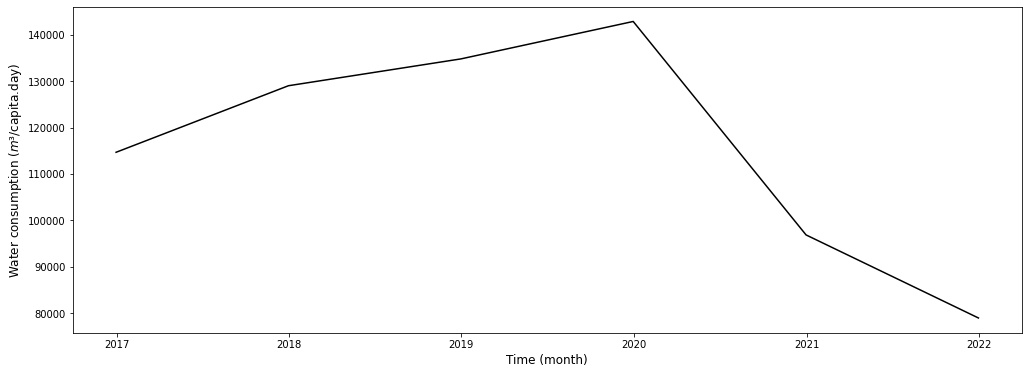

In [7]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (17, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Water consumption ($m³$/capita.day)', 
                                  {'fontsize': 12})
dataset = tmp.copy()
timeseries(tmp.index, dataset[target], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month[target], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year[target], 
           'Time (month)')

In [8]:
tmp.isna().any(axis=0).sum()
tmp.dropna(axis= 0 ,inplace=True)

In [9]:
# Split train data and test data
train_size = int(len(tmp)*0.7)

train_data = tmp.iloc[:train_size]
test_data = tmp.iloc[train_size:]

In [10]:
test_data

,Israelis_Count,region_Central,region_Judea_Samaria,region_North,region_South,is_weekend,operations,is_jewish_holiday,is_jewish_vacation,is_muslims_holiday,...,Jerusalem_nox_exceeded,Haifa_nox_exceeded,Ashkelon_nox_exceeded,Beer-Sheva_nox_exceeded,Green_border,Season_autumn,Season_spring,Season_summer,Season_winter,Day_before_Total
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-19,331,0,0,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,489
2019-08-20,277,0,0,1,0,0,0,0,1,0,...,1,1,0,1,0,0,0,1,0,331
2019-08-21,202,0,0,1,0,0,0,0,1,0,...,1,1,0,1,0,0,0,1,0,277
2019-08-22,485,0,0,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,202
2019-08-23,93,0,0,1,0,1,0,0,1,0,...,1,1,0,0,0,0,0,1,0,485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-07,106,0,0,1,0,1,0,0,1,0,...,1,1,0,1,0,0,0,1,0,91
2021-08-08,247,0,0,1,0,0,0,0,1,0,...,1,1,0,1,0,0,0,1,0,106
2021-08-09,79,0,0,1,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,0,247


In [11]:
train_data.iloc[:,0].shape

(1073,)

In [12]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
train_scaled = scaler_train.fit_transform(train_data)
test_scaled = scaler_test.fit_transform(test_data)


In [52]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back][0])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1043, 30, 82)
y_train.shape:  (1043,)
X_test.shape:  (431, 30, 82)
y_test.shape:  (431,)


In [53]:
target_test_scaler = MinMaxScaler()
target_train_scaler = MinMaxScaler()
y_train_scaled = target_train_scaler.fit_transform([y_train]).T
y_test_scaled = target_test_scaler.fit_transform([y_test])

In [55]:
y_test_scaled.shape
y_test.shape

(431,)

In [16]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [17]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train_scaled, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
53/53 [==============================] - 15s 91ms/step - loss: 0.0324 - val_loss: 0.1731
Epoch 2/100
53/53 [==============================] - 2s 44ms/step - loss: 0.0348 - val_loss: 0.0050
Epoch 3/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 4/100
53/53 [==============================] - 2s 46ms/step - loss: 0.0025 - val_loss: 4.7051e-04
Epoch 5/100
53/53 [==============================] - 2s 45ms/step - loss: 0.0015 - val_loss: 1.8831e-04
Epoch 6/100
53/53 [==============================] - 2s 47ms/step - loss: 0.0014 - val_loss: 1.7279e-04
Epoch 7/100
53/53 [==============================] - 2s 45ms/step - loss: 0.0013 - val_loss: 9.2930e-05
Epoch 8/100
53/53 [==============================] - 2s 45ms/step - loss: 0.0011 - val_loss: 7.6800e-05
Epoch 9/100
53/53 [==============================] - 2s 47ms/step - loss: 0.0010 - val_loss: 7.2198e-05
Epoch 10/100
53/53 [==============================] - 2s 46ms/step - loss: 

In [18]:
y_test.shape

(431,)

In [19]:
y_test = target_test_scaler.inverse_transform([y_test])
y_train = target_train_scaler.inverse_transform([y_train])

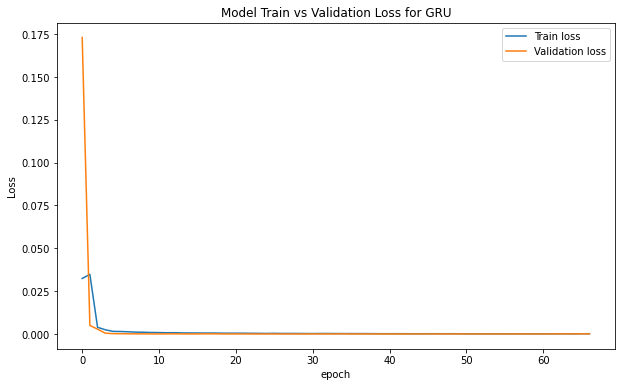

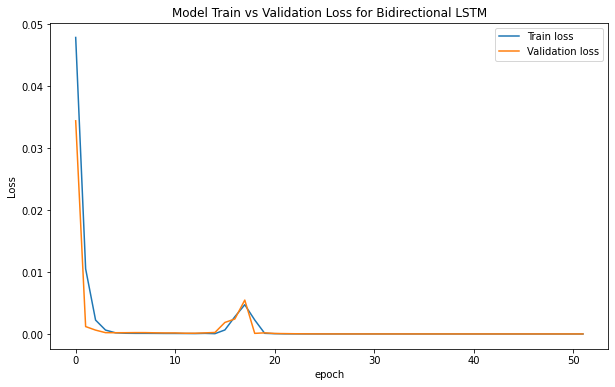

In [20]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [63]:
temp = model_gru.predict(X_test)
print(temp.shape)
temp=np.reshape(temp, (431,))
target_test_scaler.inverse_transform([temp])

(431, 1)


array([[0.02595915, 0.02110041, 0.01818752, 0.35901603, 0.4782944 ,
        0.00674545, 0.00620951, 0.07474091, 0.0560091 , 0.00999364,
        0.03265604, 0.16166755, 0.06545575, 0.34883874, 0.23727577,
        0.27465512, 0.39736414, 0.2233309 , 0.61825254, 0.3406723 ,
        0.50566368, 0.12370478, 0.0522555 , 0.26085259, 0.49098922,
        0.15312827, 0.15582032, 0.11380499, 0.49015079, 0.01755852,
        0.22436923, 0.10782687, 0.27177691, 0.11384067, 0.5383914 ,
        0.01051473, 0.32641541, 0.17087486, 0.21903522, 0.09883491,
        0.12293542, 0.07180504, 0.10891096, 0.17287189, 0.07713548,
        0.09577811, 0.15494955, 0.12871262, 0.09396212, 0.78892191,
        0.16124229, 0.10115703, 0.13548129, 0.02591199, 0.04876971,
        0.59819886, 0.04571375, 0.01465578, 0.07555745, 0.05085725,
        0.28203947, 0.07396441, 0.03019112, 0.07945836, 0.16186621,
        0.02778804, 0.03945421, 0.01343089, 0.01751242, 0.08004056,
        0.08323569, 0.02406231, 0.0333766 , 0.02

In [ ]:
# Make prediction
def prediction(model):
    predictions = model.predict(X_test)
    print(predictions.shape)
    predictions = scaler_test.inverse_transform(predictions)
    return predictions
    #print(predictions.shape)

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m³$/capita.day)')
 
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

(431, 1)


ValueError: non-broadcastable output operand with shape (431,1) doesn't match the broadcast shape (431,82)